In [ ]:
import os.path
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from scipy.stats import norm, moment, pearsonr, probplot

from scipy import signal
from statsmodels.tsa.stattools import acf, pacf

np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset 1

## Ruído gerado pelo tubo fotomultiplicador Hammamatsu R7378A numa janela de tempo de 100 ns

#### 608 instâncias (ruídos)
#### Cada ruído possui 500 amostras (Ts = 0.2ns -> Janela de 100ns)
#### V.A: Amplitude (V)

O banco de dados era pra ser dados de sinais de um photoelectron, porem parte dos sinais são apenas ruidos, devido a eficiencia quantica, etc.

A configuração utilizada para adquirir dados do sinal SPE consiste no Hamamatsu PMT R7378A,
operado a uma tensão de alimentação de 900 V, e um gerador de pulsos de luz (GLP). O osciloscópio Tedeldyne
Lecroy WaveSurfer 4104HD (63) foi utilizado para realizar as medições. Suas
especificações técnicas mais relevantes para nossa análise são apresentadas na Tabela 5.

Analog Sample Rate 5 GS/s

Nesse trabalho a ideia é fazer a modelagem do ruido apenas.

In [ ]:
noise_dataset = np.load('/content/drive/MyDrive/Mestrado/Processos Estocásticos/Trabalho/noise_dataset.npy')
dataset = noise_dataset[:, 502:]
#dataset = noise_dataset[:, 0:350]

In [ ]:
from scipy.io import savemat

savemat('dataset.mat', {'data': dataset})

In [ ]:
print(f'Número de instâncias: {dataset.shape[0]}')

Número de instâncias: 608


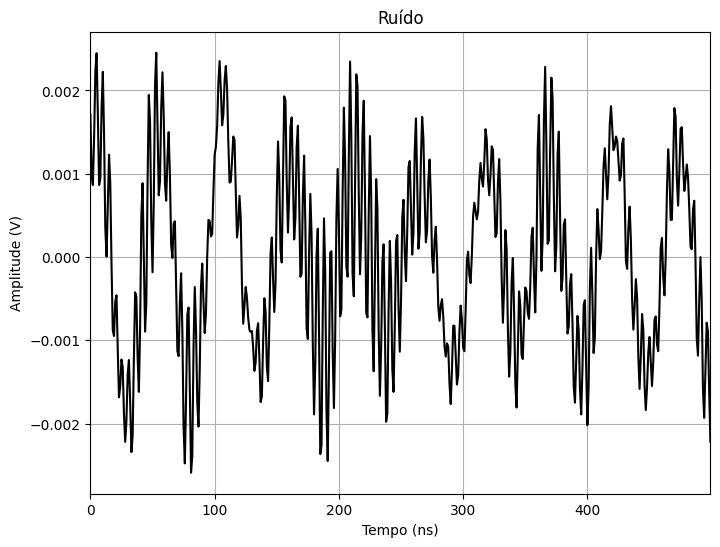

In [ ]:
plt.figure(figsize = (8,6), dpi = 100)
plt.plot(dataset[431], color = 'k')
plt.title(f'Ruído')
plt.xlabel('Tempo (ns)')
plt.ylabel('Amplitude (V)')
plt.grid()
plt.autoscale(1, 'x', 1)
plt.show()

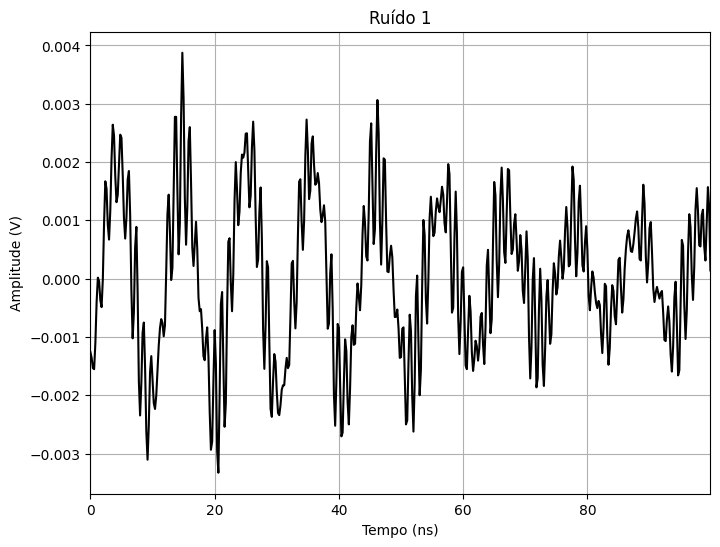

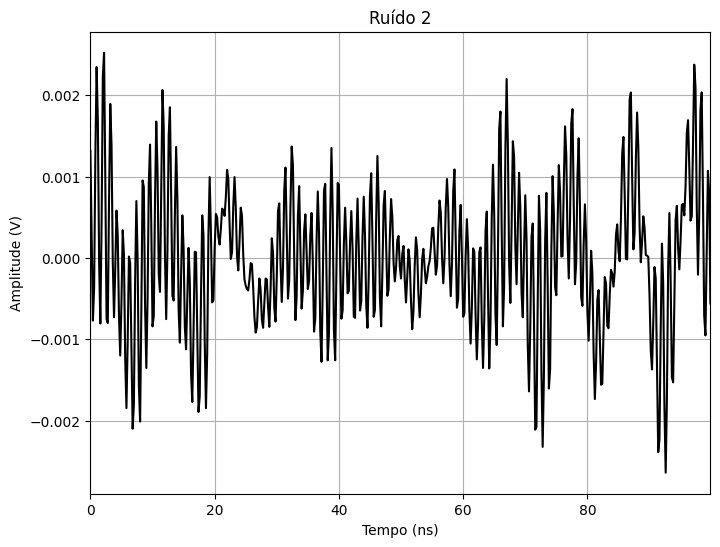

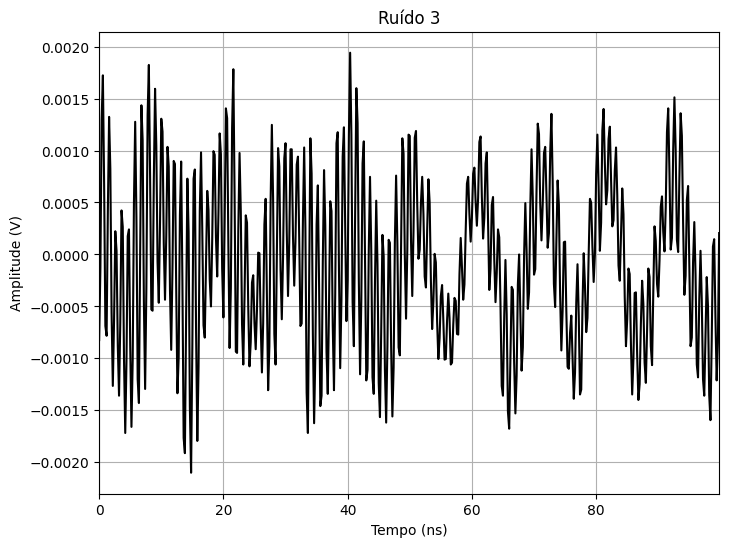

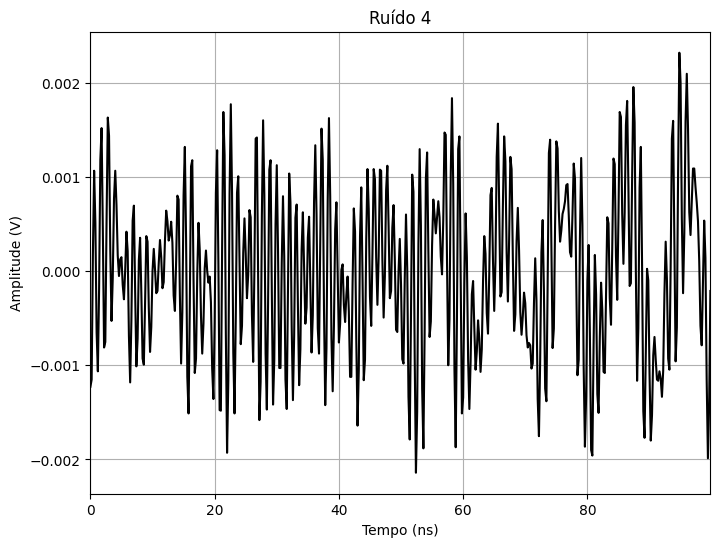

In [ ]:
t = np.arange(dataset.shape[1]) * 0.2e-9

for i in range (1, 5):

  plt.figure(figsize = (8,6), dpi = 100)
  plt.plot(t *1e9, dataset[i], color = 'k')
  plt.title(f'Ruído {i}')
  plt.xlabel('Tempo (ns)')
  plt.ylabel('Amplitude (V)')
  plt.grid()
  plt.autoscale(1, 'x', 1)
  plt.show()

## Modelagem como Variável Aleatória

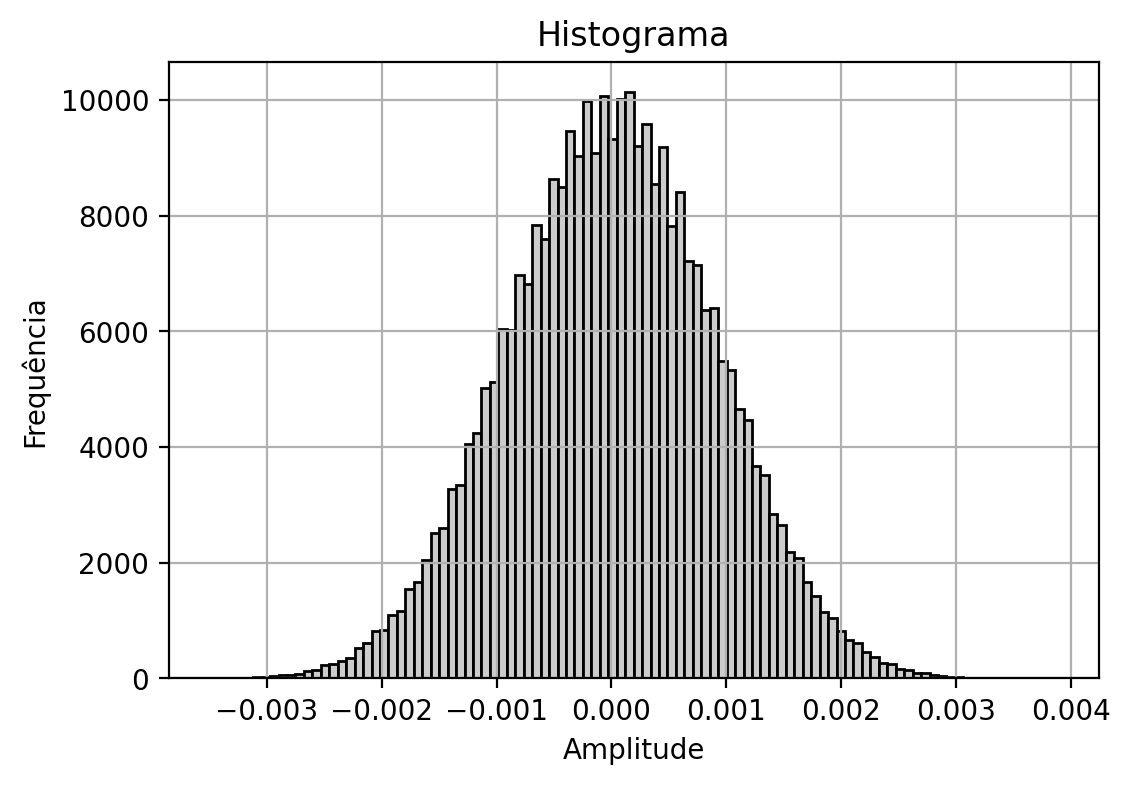

In [ ]:
# --- Histograma ---

plt.figure(figsize = (6,4), dpi = 200)
plt.hist(dataset.flatten(), bins=100, color='0.8', edgecolor='black')
plt.title('Histograma')
plt.xlabel('Amplitude')
plt.ylabel('Frequência')
plt.grid()
plt.show()

In [ ]:
# --- Estatísticas principais ---
print("Média:", np.mean(dataset))
print("Desvio padrão:", np.std(dataset))
print("Variância:", np.var(dataset))

Média: -1.7605273646585517e-07
Desvio padrão: 0.0008992950632915937
Variância: 8.087316108606315e-07


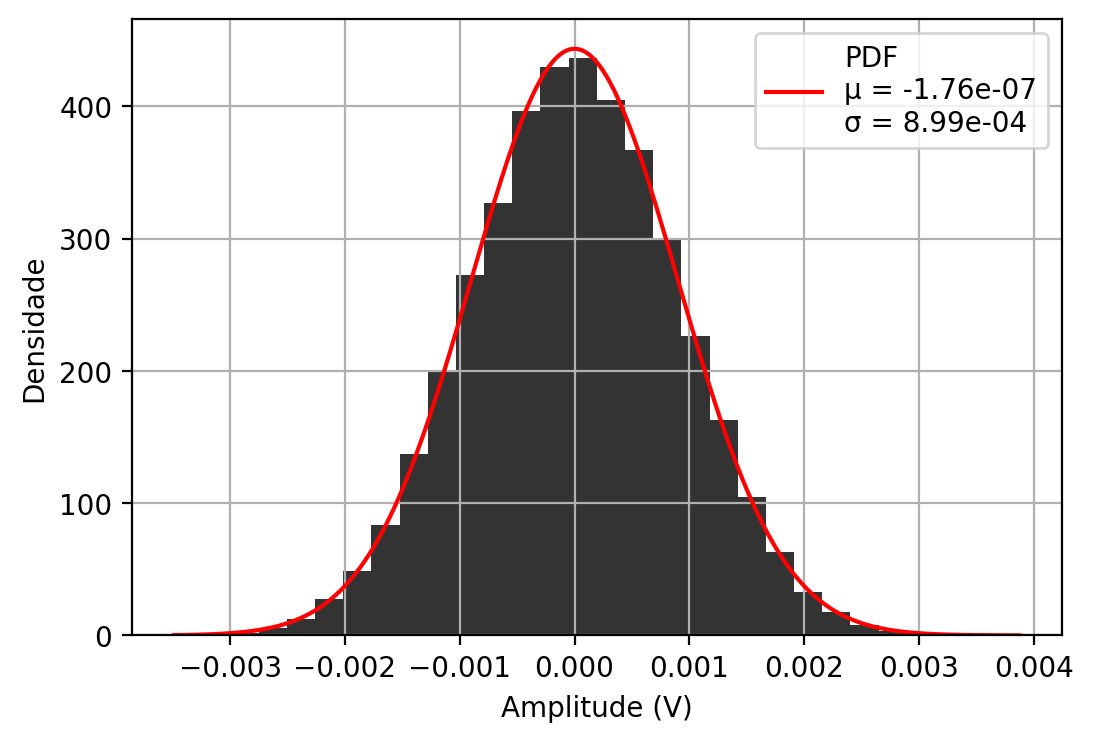

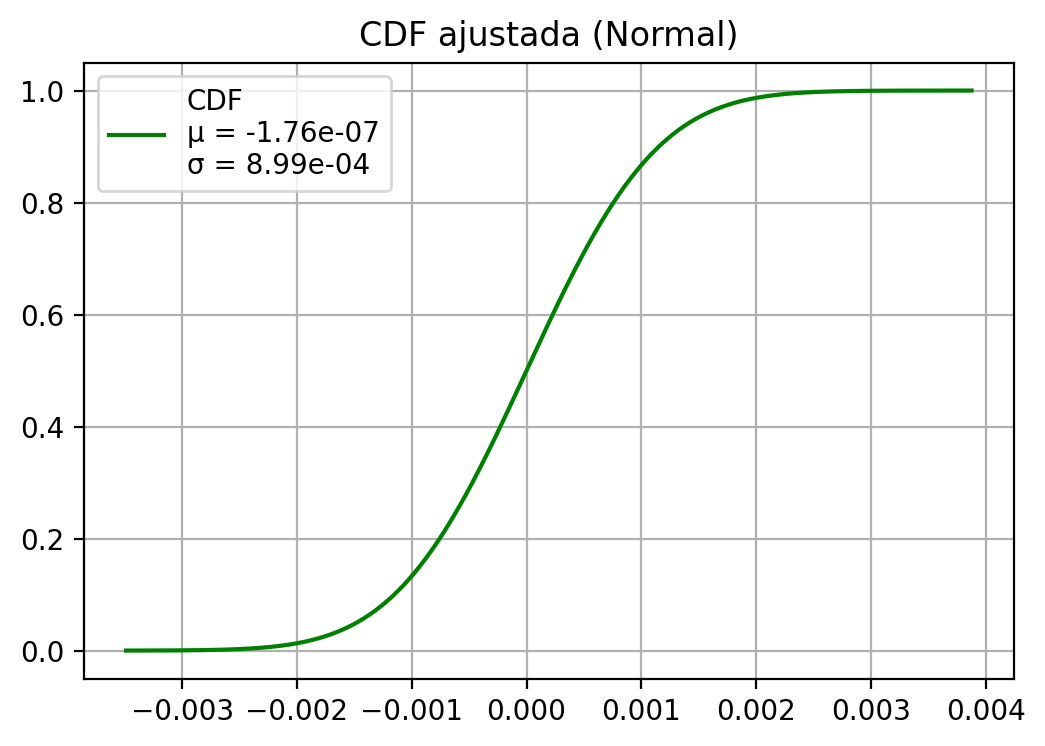

In [ ]:
# --- Ajuste de distribuição normal (makedist, pdf, cdf) ---
# Ajuste da normal
mu, sigma = norm.fit(dataset)

x = np.linspace(min(dataset.flatten()), max(dataset.flatten()), len(dataset))
pdf_vals = norm.pdf(x, mu, sigma)
cdf_vals = norm.cdf(x, mu, sigma)

# PDF
plt.figure(figsize=(6, 4), dpi=200)
plt.hist(dataset.flatten(), bins=30, density=1, color = 'k', alpha = 0.8)
plt.plot(x, pdf_vals,
         label=f'PDF\nμ = {mu:.2e}\nσ = {sigma:.2e}',
         color='r')
#plt.title('PDF ajustada (Normal)')
plt.ylabel("Densidade")
plt.xlabel("Amplitude (V)")
plt.grid()
plt.legend()
plt.show()

# CDF
plt.figure(figsize=(6, 4), dpi=200)
plt.plot(x, cdf_vals,
         label=f'CDF\nμ = {mu:.2e}\nσ = {sigma:.2e}',
         color='green')
plt.title('CDF ajustada (Normal)')
plt.grid()
plt.legend()
plt.show()

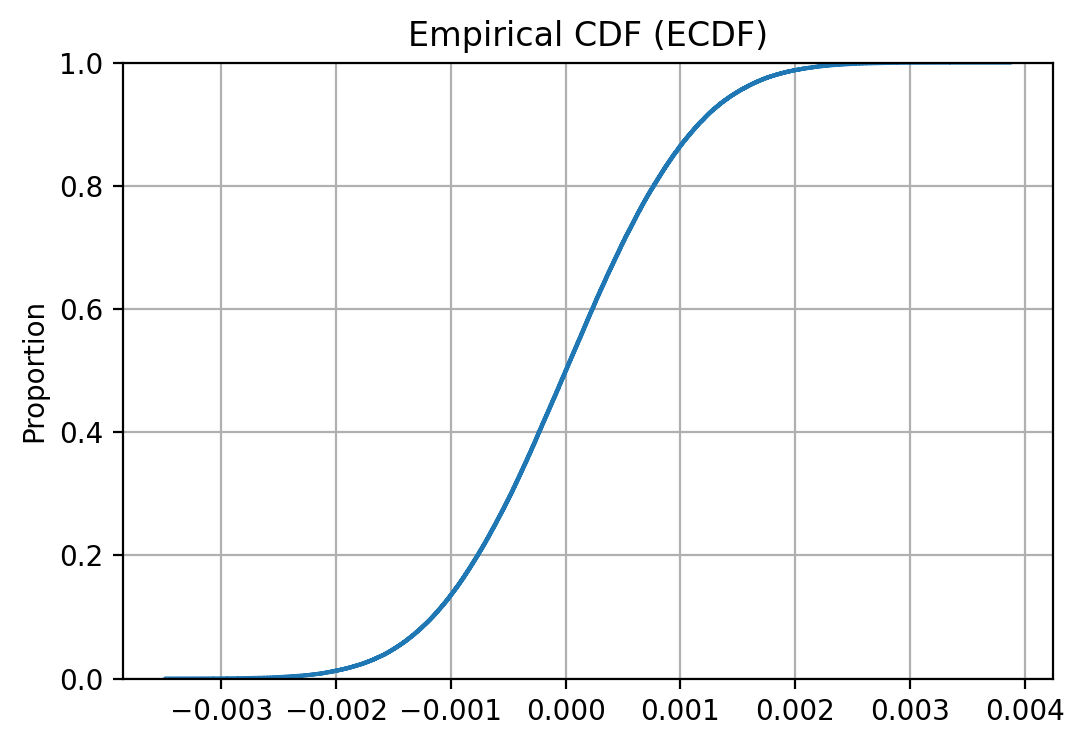

In [ ]:
# --- CDF Empírica (cdfplot) ---
plt.figure(figsize = (6,4), dpi = 200)
sns.ecdfplot(dataset.flatten())
plt.title('Empirical CDF (ECDF)')
plt.grid()
plt.show()

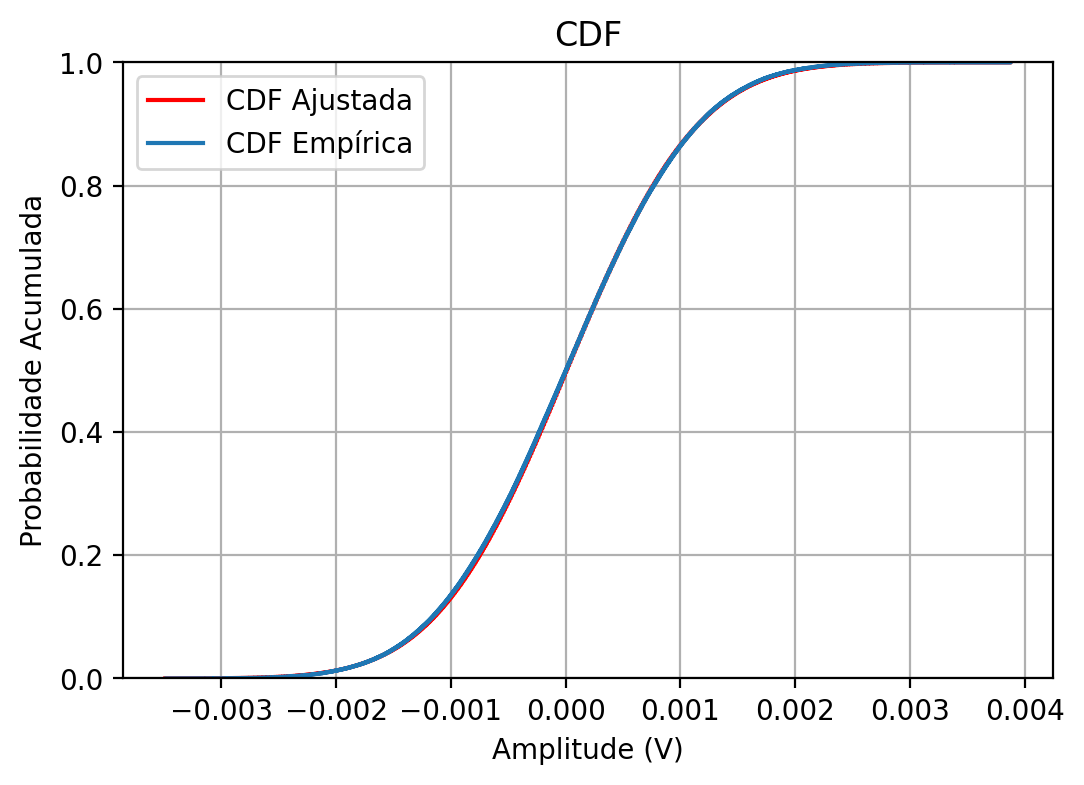

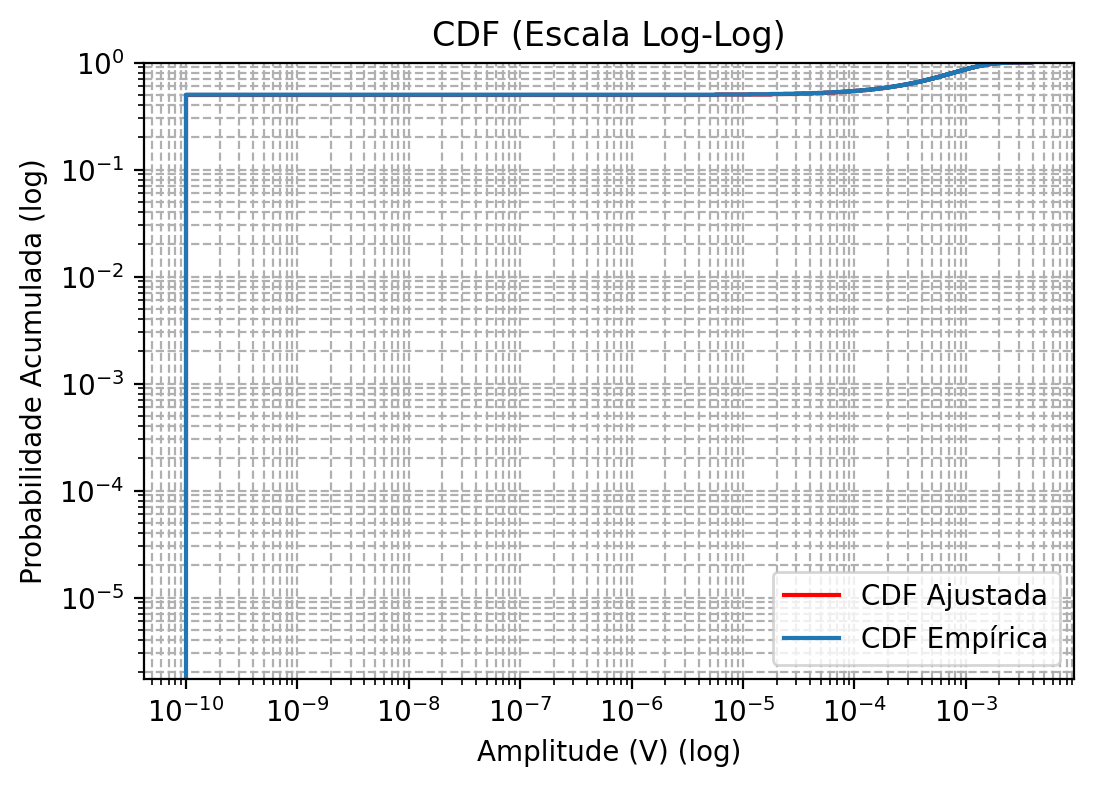

In [ ]:
# --- Plot CDF ---
plt.figure(figsize = (6,4), dpi = 200)
plt.step(x, cdf_vals, where='post', color='red', label=f'CDF Ajustada')
sns.ecdfplot(dataset.flatten(), label=f'CDF Empírica')
plt.title('CDF')
plt.xlabel('Amplitude (V)')
plt.ylabel('Probabilidade Acumulada')
plt.grid()
plt.legend()
plt.show()

epsilon = 1e-10
x_log = np.clip(x, epsilon, None)
cdf_vals_log = np.clip(cdf_vals, epsilon, 1 - epsilon)
dataset_log = np.clip(dataset.flatten(), epsilon, None)

# --- Plot CDF com escala log ---
plt.figure(figsize=(6, 4), dpi=200)
plt.step(x_log, cdf_vals_log, where='post', color='red', label=f'CDF Ajustada')
sns.ecdfplot(dataset_log, label='CDF Empírica')
plt.xscale('log')
plt.yscale('log')
plt.title('CDF (Escala Log-Log)')
plt.xlabel('Amplitude (V) (log)')
plt.ylabel('Probabilidade Acumulada (log)')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

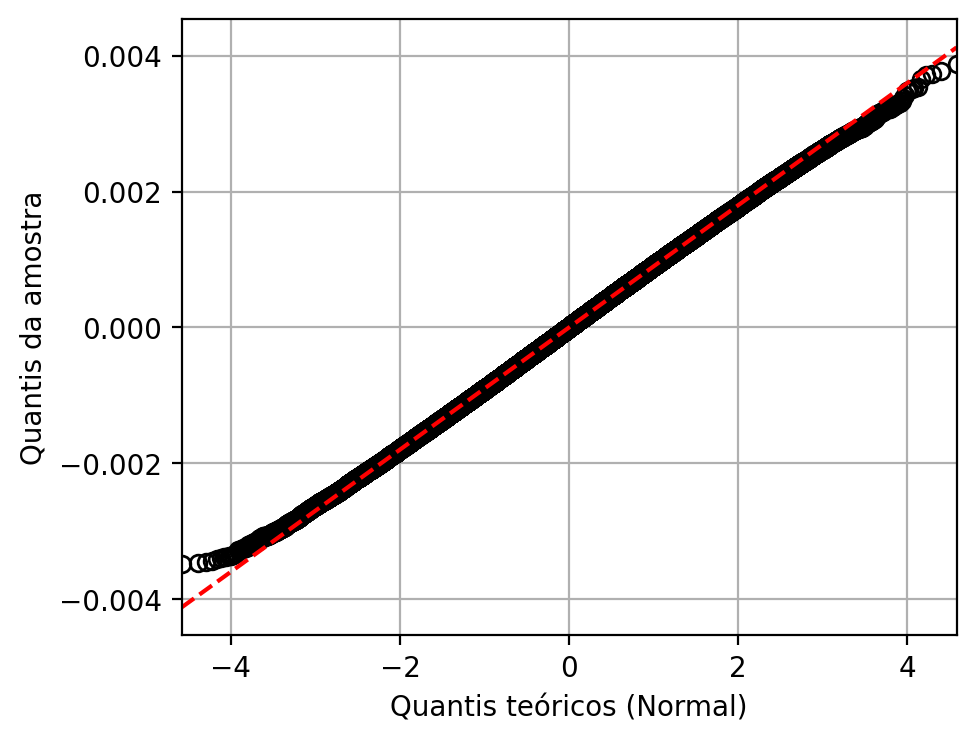

In [ ]:
# --- QQ Plot ---
plt.figure(figsize=(5, 4), dpi=200)

res = probplot(dataset.flatten(), dist="norm")

# res[0] = (quantis teóricos, quantis da amostra)
# res[1] = (slope, intercept, r, ...)
theoretical_quants, sample_quants = res[0]
slope, intercept = res[1][0], res[1][1]

# Plot: marcadores (círculos sem preenchimento)
plt.plot(theoretical_quants, sample_quants, 'o',
         markerfacecolor='none', markeredgecolor='k')

# Plot linha de ajuste
plt.plot(theoretical_quants,
         slope * theoretical_quants + intercept,
         color='r', linestyle='--')

plt.xlabel('Quantis teóricos (Normal)')
plt.ylabel('Quantis da amostra')
plt.title('')
plt.grid()
plt.autoscale(1,'x', 1)
#plt.legend()
plt.show()

In [ ]:
# --- Estatísticas principais ---
mean = np.mean(dataset)
sigma = np.std(dataset)
var = np.var(dataset)

print(f"Média: {mean*1e3:.5f} mV")
print(f"Desvio padrão: {sigma*1e3:.5f} mV")
print("Variância:", var)

Média: -0.00018 mV
Desvio padrão: 0.89930 mV
Variância: 8.087316108606315e-07


Testes de hipótese:

## Modelagem como Processo Estocástico

In [ ]:
# Parâmetros do sistema
num_instancias = dataset.shape[0]
num_amostras = dataset.shape[1]
fs = 5e9  # Taxa de amostragem: 5 GHz
Ts = 1 / fs # Período de amostragem: 0.2 ns
nyquist_freq = 0.5 * fs
tempo_total = num_amostras * Ts
print(f"Dataset carregado com {num_instancias} instâncias e {num_amostras} amostras por instância.")
print(f"Período de amostragem: {Ts*1e9:.2f} ns. Janela de tempo: {tempo_total*1e9:.2f} ns.")

Dataset carregado com 608 instâncias e 500 amostras por instância.
Período de amostragem: 0.20 ns. Janela de tempo: 100.00 ns.


Média de Conjunto Global: -0.000000
Variância de Conjunto Global: 8.040393e-07


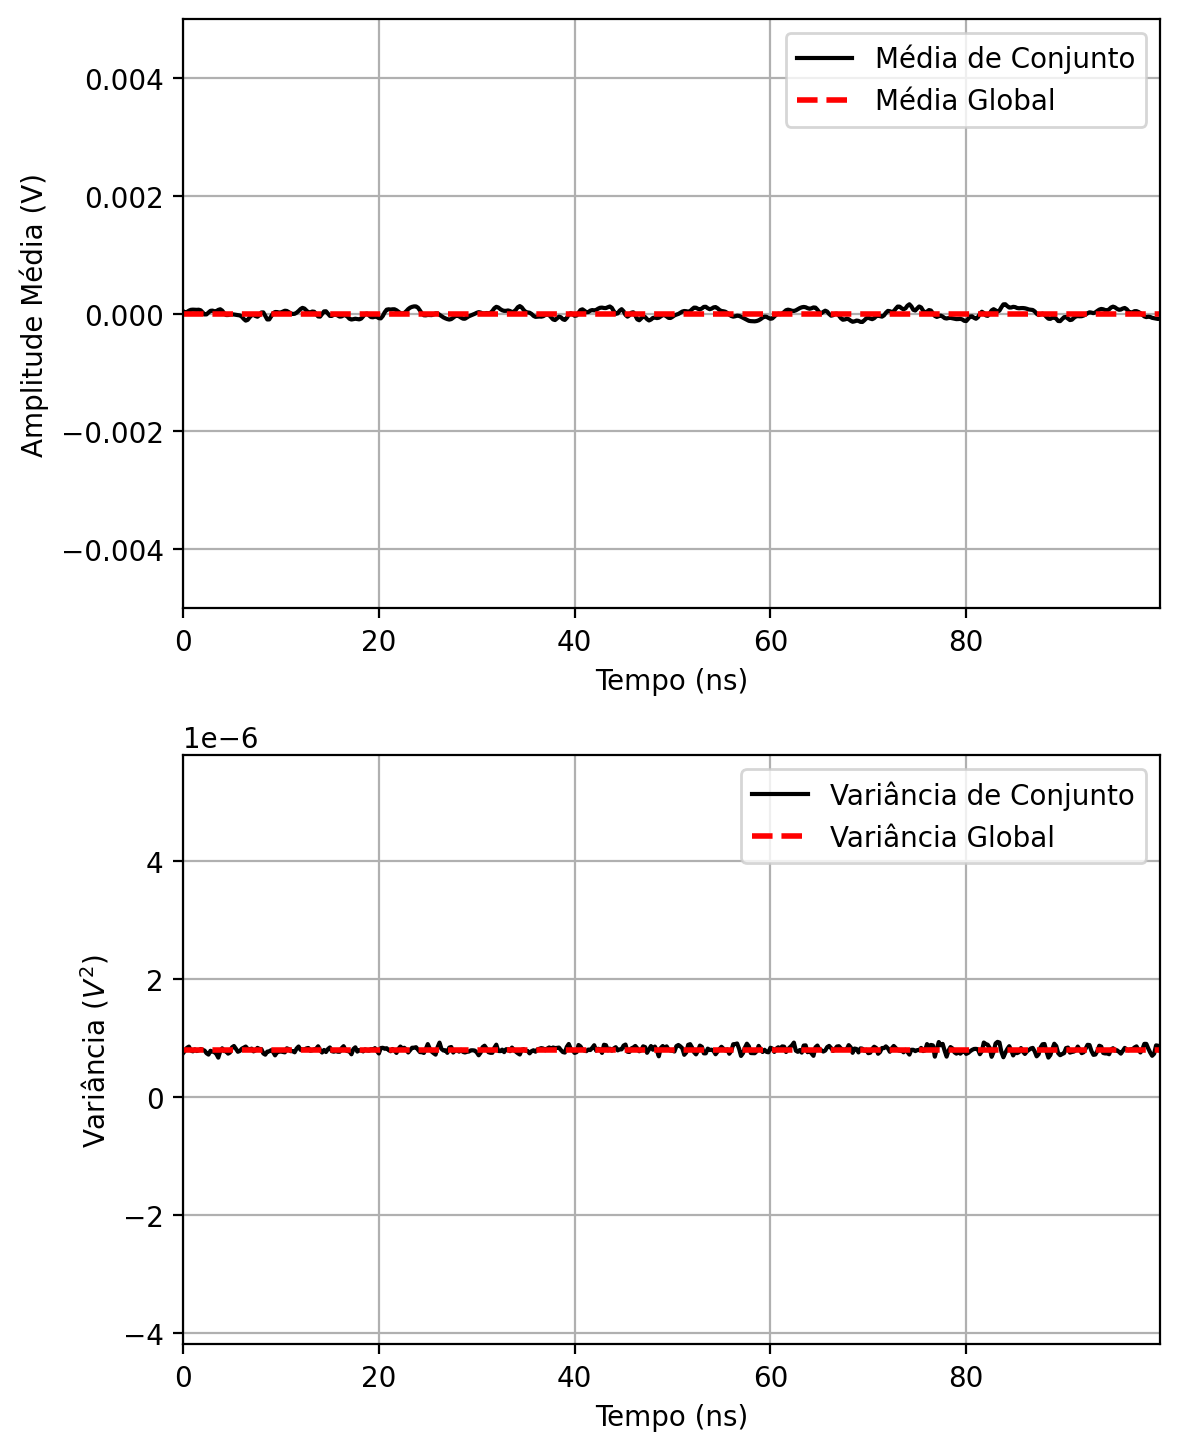

Calculamos 608 médias temporais e 608 variâncias temporais.


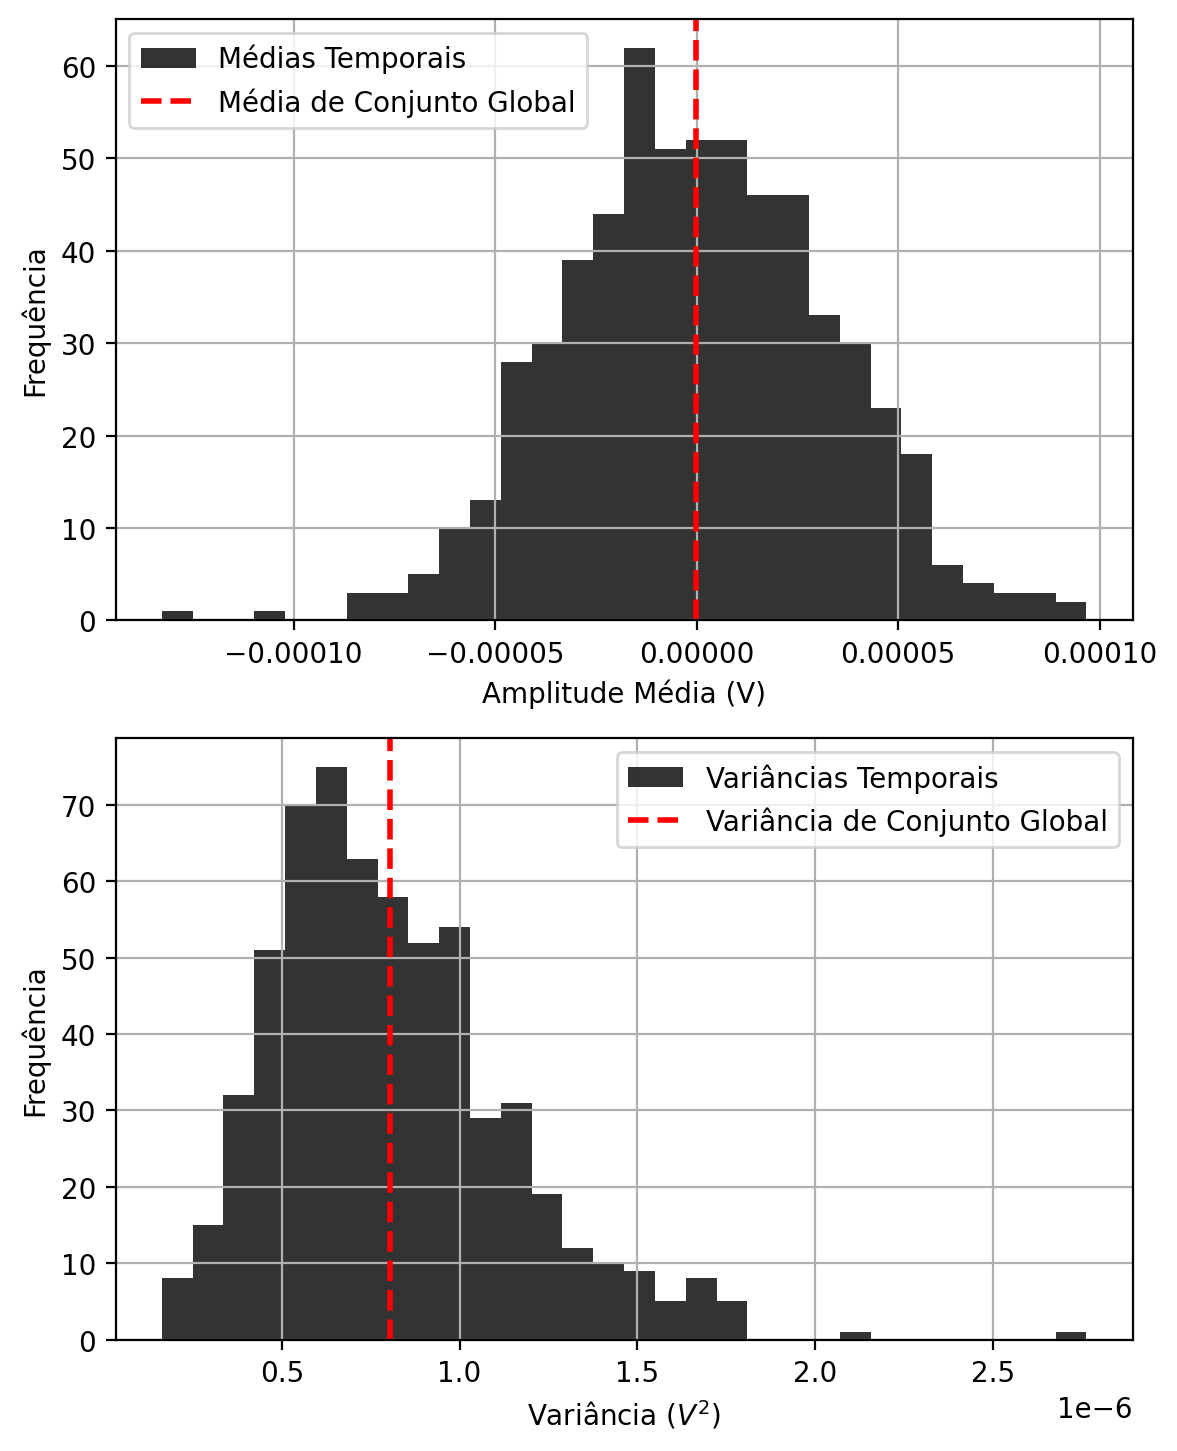

In [ ]:
# --- Análise de Estacionariedade ---

# Média de conjunto em cada instante de tempo
media_de_conjunto_vs_tempo = np.mean(dataset, axis=0)

# Variância de conjunto em cada instante de tempo
variancia_de_conjunto_vs_tempo = np.var(dataset, axis=0)

# Média de conjunto GLOBAL
media_de_conjunto_global = np.mean(media_de_conjunto_vs_tempo)

# Variância de conjunto GLOBAL
variancia_de_conjunto_global = np.mean(variancia_de_conjunto_vs_tempo)

print(f"Média de Conjunto Global: {media_de_conjunto_global:.6f}")
print(f"Variância de Conjunto Global: {variancia_de_conjunto_global:.6e}")

# Eixo do tempo para os gráficos
eixo_tempo = np.arange(num_amostras) * Ts * 1e9 # em nanosegundos

# --- Plotar os Resultados ---
plt.figure(figsize=(6, 8), dpi=200)
#plt.suptitle('Análise de Estacionariedade', fontsize=16)

# Gráfico da Média
plt.subplot(2, 1, 1)
plt.plot(eixo_tempo, media_de_conjunto_vs_tempo, label='Média de Conjunto', color = 'k')
# Adicionar a linha da média global
plt.axhline(media_de_conjunto_global, color='r', linestyle='--', linewidth=2, label=f'Média Global')
#plt.title('Média de Conjunto')
plt.xlabel('Tempo (ns)')
plt.ylabel('Amplitude Média (V)')
plt.ylim(media_de_conjunto_global-0.005, media_de_conjunto_global+0.005)
plt.grid(True)
plt.autoscale(1,'x', 1)
plt.legend()

# Gráfico da Variância
plt.subplot(2, 1, 2)
plt.plot(eixo_tempo, variancia_de_conjunto_vs_tempo, label='Variância de Conjunto', color = 'k')
# Adicionar a linha da variância global
plt.axhline(variancia_de_conjunto_global, color='r', linestyle='--', linewidth=2, label=f'Variância Global')
#plt.title('Variância de Conjunto')
plt.xlabel('Tempo (ns)')
plt.ylabel(r'Variância ($V^2$)')
plt.ylim(variancia_de_conjunto_global - 5e-6, variancia_de_conjunto_global + 5e-6)
plt.grid(True)
plt.autoscale(1,'x', 1)
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Análise de Ergodicidade ---

# --- 2. Calcular as Médias Temporais (para cada instância) ---
medias_temporais = np.mean(dataset, axis=1)  # Média de cada uma das 608 instâncias
variancias_temporais = np.var(dataset, axis=1) # Variância de cada uma das 608 instâncias

print(f"Calculamos {len(medias_temporais)} médias temporais e {len(variancias_temporais)} variâncias temporais.")

# --- 3. Comparar os Resultados com Histogramas ---
plt.figure(figsize=(6, 8), dpi=200)
#plt.suptitle('Análise de Ergodicidade', fontsize=16)

# Histograma das médias temporais
plt.subplot(2, 1, 1)
plt.hist(medias_temporais, bins=30, density=False, label='Médias Temporais', color = 'k', alpha = 0.8)
plt.axvline(media_de_conjunto_global, color='r', linestyle='--', linewidth=2, label='Média de Conjunto Global')
#plt.title('Comparação das Médias')
plt.xlabel('Amplitude Média (V)')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True)

# Histograma das variâncias temporais
plt.subplot(2, 1, 2)
plt.hist(variancias_temporais, bins=30, density=False, label='Variâncias Temporais', color = 'k', alpha = 0.8)
plt.axvline(variancia_de_conjunto_global, color='r', linestyle='--', linewidth=2, label='Variância de Conjunto Global')
#plt.title('Comparação das Variâncias')
plt.xlabel(r'Variância ($V^2$)')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Verificar estacionariedade do resíduo com teste ADF
for i in range(len(dataset)):
  adf_test = adfuller(dataset[i])
  if adf_test[1] > 0.05:
    print(f"Instância {i}: Resíduo não estacionário. p-valor: {adf_test[1]:.4f}")
#print(f"P-valor do Teste ADF no Resíduo: {adf_test[1]:.4f}")
# Um p-valor baixo (< 0.05) indica que a série é estacionária.

In [ ]:
cov = np.cov(dataset.T)  # ou autocorrelação

# Rótulos (opcional)
labels = [f'Var{i+1}' for i in range(dataset.shape[1])]

# Converter para DataFrame para visualização mais clara
cov_df = pd.DataFrame(cov, index=labels, columns=labels)

cov_df

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var491,Var492,Var493,Var494,Var495,Var496,Var497,Var498,Var499,Var500
Var1,7.467002e-07,5.526555e-07,1.539428e-07,-1.288204e-08,2.086469e-07,5.329983e-07,5.844236e-07,3.179822e-07,3.679456e-08,6.605498e-09,...,-7.761304e-08,2.601138e-08,-3.381616e-10,-1.370955e-07,-2.230390e-07,-1.618233e-07,-3.454734e-08,3.498544e-09,-9.112158e-08,-1.965408e-07
Var2,5.526555e-07,7.895390e-07,5.862519e-07,1.739523e-07,8.329349e-09,2.399708e-07,5.657047e-07,5.948440e-07,2.985654e-07,3.744960e-09,...,-2.098917e-07,-1.762560e-07,-7.293352e-08,-2.918462e-08,-9.686884e-08,-1.928173e-07,-2.010718e-07,-1.149503e-07,-4.522342e-08,-6.809201e-08
Var3,1.539428e-07,5.862519e-07,8.393259e-07,6.307966e-07,1.989876e-07,1.578231e-08,2.423170e-07,5.681611e-07,5.970103e-07,2.992237e-07,...,-2.016894e-07,-3.252022e-07,-2.504888e-07,-5.936270e-08,2.573272e-08,-9.182391e-08,-2.727023e-07,-3.013246e-07,-1.454180e-07,1.544763e-08
Var4,-1.288204e-08,1.739523e-07,6.307966e-07,8.598036e-07,6.070523e-07,1.565721e-07,-3.774462e-09,2.623447e-07,6.044827e-07,6.173470e-07,...,-6.873586e-08,-2.355316e-07,-3.026105e-07,-1.797984e-07,-5.872812e-09,1.105240e-08,-1.653288e-07,-3.291015e-07,-2.756043e-07,-6.139067e-08
Var5,2.086469e-07,8.329349e-09,1.989876e-07,6.070523e-07,7.937934e-07,5.524010e-07,1.556489e-07,4.242426e-08,3.062658e-07,6.100108e-07,...,4.031597e-08,5.255470e-09,-1.397076e-07,-2.284320e-07,-1.561763e-07,-1.809625e-08,-5.377451e-09,-1.451296e-07,-2.598796e-07,-2.088843e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Var496,-1.618233e-07,-1.928173e-07,-9.182391e-08,1.105240e-08,-1.809625e-08,-1.446100e-07,-2.068049e-07,-1.161101e-07,2.143713e-08,4.214422e-08,...,5.060772e-07,2.267306e-07,2.612406e-08,1.692780e-07,5.260558e-07,7.035448e-07,4.964923e-07,1.338345e-07,1.212666e-08,2.369318e-07
Var497,-3.454734e-08,-2.010718e-07,-2.727023e-07,-1.653288e-07,-5.377451e-09,1.991868e-08,-1.050702e-07,-2.073374e-07,-1.532920e-07,-1.077445e-08,...,5.696893e-07,5.993021e-07,3.219408e-07,5.959093e-08,1.388102e-07,4.964923e-07,7.383151e-07,5.903890e-07,2.188682e-07,2.802645e-08
Var498,3.498544e-09,-1.149503e-07,-3.013246e-07,-3.291015e-07,-1.451296e-07,4.788115e-08,3.287127e-08,-1.555419e-07,-2.738725e-07,-1.698038e-07,...,3.434513e-07,6.861768e-07,6.837548e-07,3.213114e-07,1.114443e-08,1.338345e-07,5.903890e-07,8.805799e-07,6.729745e-07,1.957888e-07
Var499,-9.112158e-08,-4.522342e-08,-1.454180e-07,-2.756043e-07,-2.598796e-07,-9.379806e-08,3.328328e-08,-2.964476e-08,-1.969279e-07,-2.468936e-07,...,7.394277e-08,3.919839e-07,6.778258e-07,6.076175e-07,2.449745e-07,1.212666e-08,2.188682e-07,6.729745e-07,8.747400e-07,5.946541e-07


--- Calculando ACF via Matriz de Autocorrelação ---


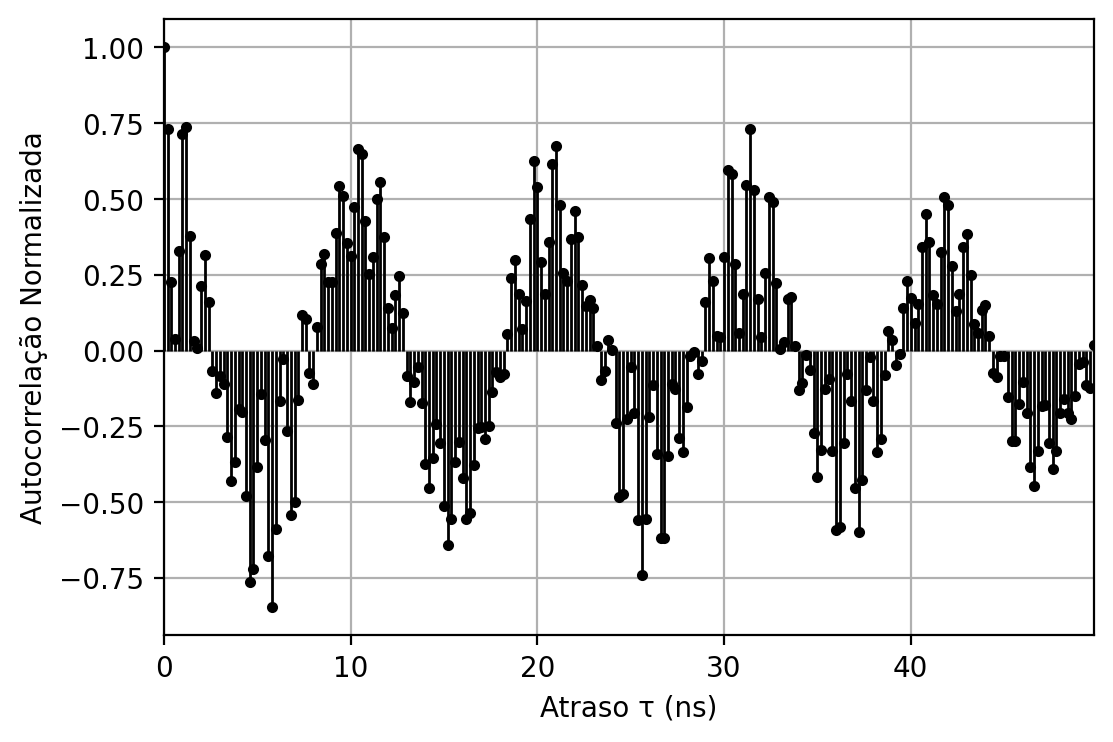

In [ ]:
# Parâmetros
nlags = 250

# --- Calcular ACF média via Matriz de Autocorrelação --
print("--- Calculando ACF via Matriz de Autocorrelação ---")

# 1. Calcular a matriz de autocorrelação 500x500 pela definição
#    R = E[X' * X]. A média de conjunto (E[]) é a média sobre as instâncias.
autocorr_matrix = (dataset.T @ dataset) / num_instancias

# 2. Extrair a ACF fazendo a média das diagonais da matriz
acf_via_matrix = []
for lag in range(nlags):
    diagonal_values = np.diagonal(autocorr_matrix, offset=lag)
    acf_via_matrix.append(np.mean(diagonal_values))

# Normalizar pelo valor em lag=0 para que R(0)=1
acf_via_matrix = np.array(acf_via_matrix) / acf_via_matrix[0]

# --- Plot ---
eixo_lags = np.arange(nlags) * Ts * 1e9
#eixo_lags = np.arange(nlags)

plt.figure(figsize=(6, 4), dpi=200)
stem1 = plt.stem(eixo_lags, acf_via_matrix, basefmt=' ', linefmt='k-')
plt.setp(stem1.markerline, markersize=3)
plt.setp(stem1.stemlines, linewidth=1)
plt.xlabel('Atraso τ (ns)')
plt.ylabel('Autocorrelação Normalizada')
plt.grid(True)
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

--- Calculando a ACF a partir da matriz de autocorrelação ---
--- Calculando a PSD via Transformada de Fourier da ACF ---
Fator de Correção de Energia Teórico: 1.5879
O modelo (filtro ótimo) é composto por 500 coeficientes.


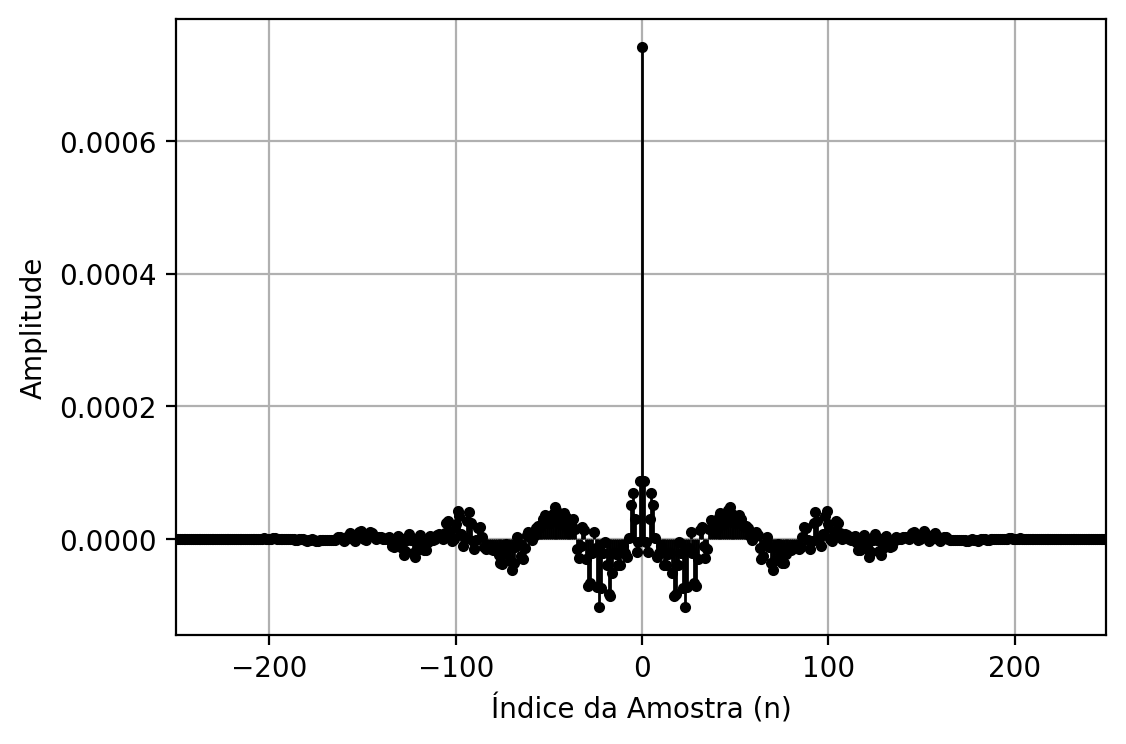

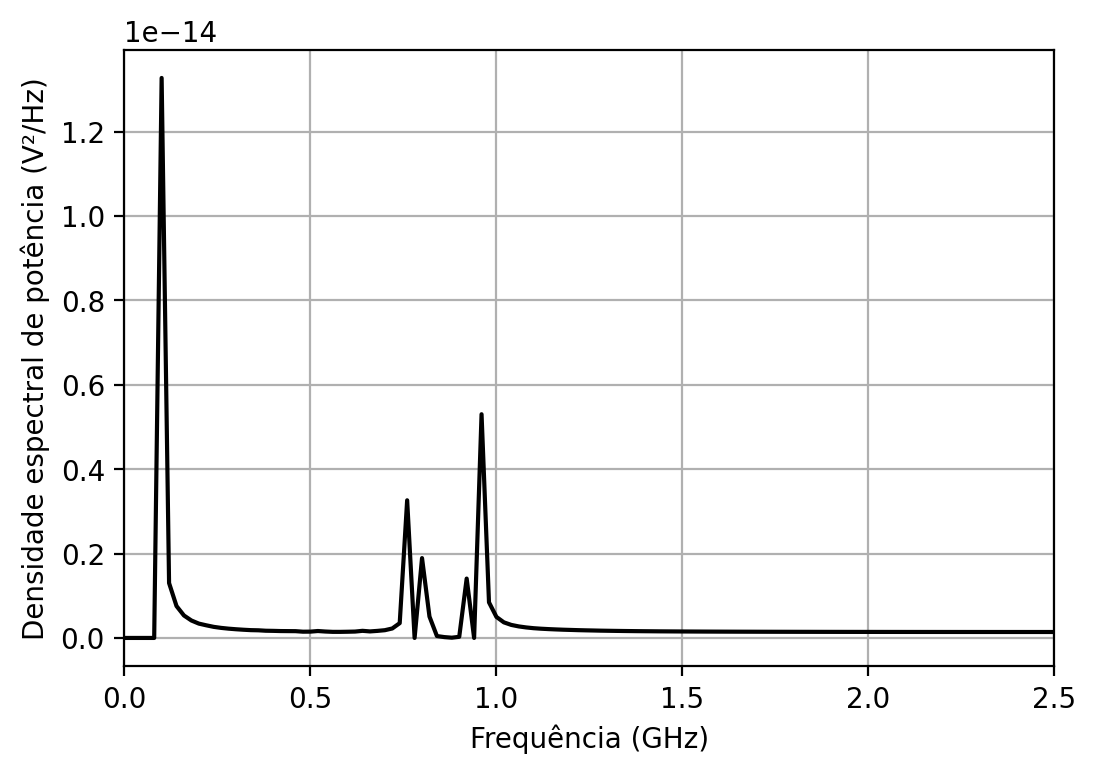

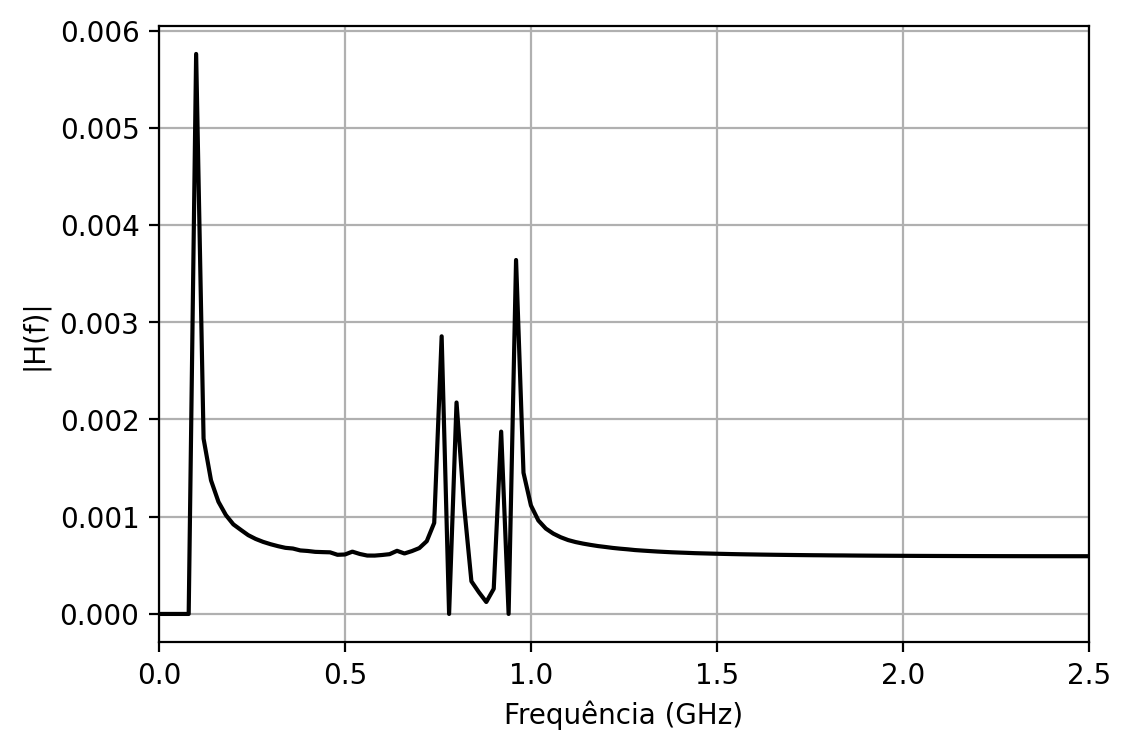

Frequências dos picos (GHz): [0.1  0.76 0.8  0.92 0.96]


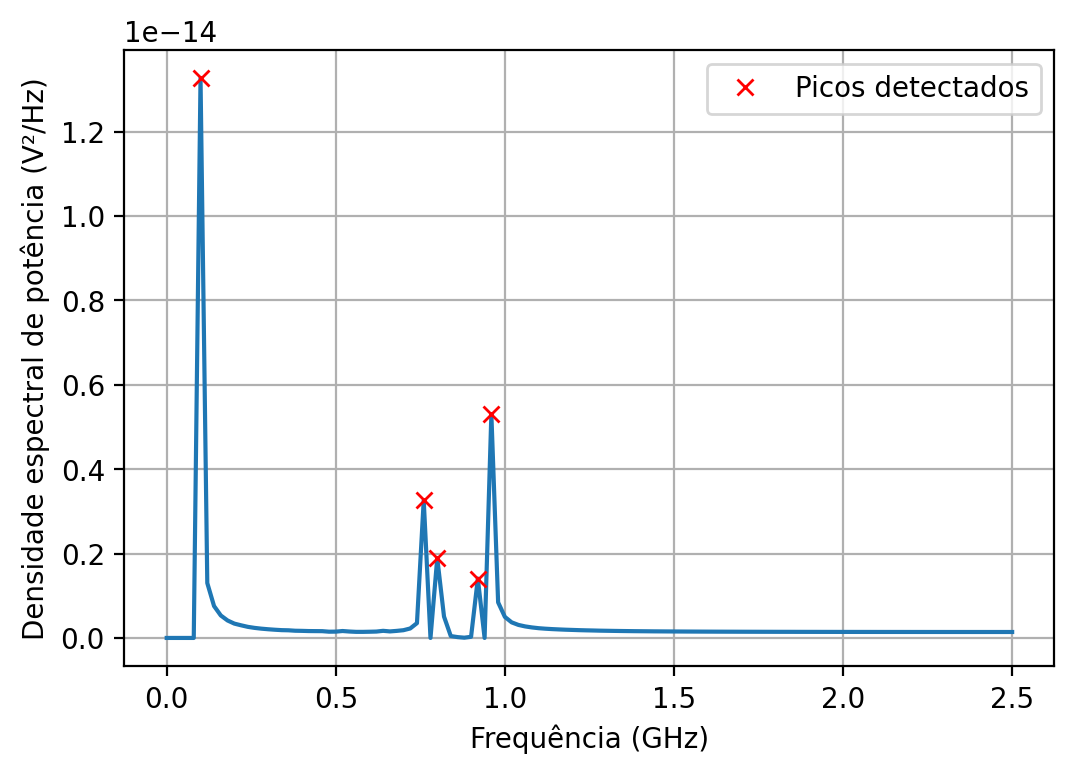

In [ ]:
# --- 1. Calcular a ACF pelo método da Matriz ---
print("--- Calculando a ACF a partir da matriz de autocorrelação ---")
# Nota: Usamos a ACF não normalizada aqui, pois ela contém a informação da potência (R[0] = Potência)
autocorr_matrix = (dataset.T @ dataset) / num_instancias
acf_via_matrix_unnormalized = []
for lag in range(nlags):
    diagonal_values = np.diagonal(autocorr_matrix, offset=lag)
    acf_via_matrix_unnormalized.append(np.mean(diagonal_values))
acf_via_matrix_unnormalized = np.array(acf_via_matrix_unnormalized)

# --- 2. Calcular a PSD a partir da ACF (Teorema de Wiener-Khinchin) ---
print("--- Calculando a PSD via Transformada de Fourier da ACF ---")
# A PSD é a FFT da ACF. Multiplicamos por 2 para obter o espectro de lado único
# e por Ts para ajustar a escala de soma para densidade.
# Usamos .real pois o resultado deve ser real para uma ACF simétrica.
psd_via_acf = 2 * Ts * np.fft.rfft(acf_via_matrix_unnormalized).real
psd_via_acf = np.maximum(psd_via_acf, 0)
freqs_via_acf = np.fft.rfftfreq(nlags, d=Ts)

# --- 3. Calcular os Coeficientes do Filtro Ótimo h[n] ---
# A resposta em frequência do filtro é a raiz da PSD
H_f = np.sqrt(psd_via_acf / Ts / 2)

freqs_saida = np.fft.rfftfreq(num_amostras, d=Ts)

H_f_interpolado = np.interp(freqs_saida, freqs_via_acf, H_f)

coeficientes_h_n = np.fft.irfft(H_f_interpolado, n=num_amostras)
coeficientes_h_n = np.fft.fftshift(coeficientes_h_n)

janela_hamming = signal.windows.hamming(num_amostras)

rms_da_janela = np.sqrt(np.mean(janela_hamming**2))
fator_correcao_teorico = 1 / rms_da_janela

print(f"Fator de Correção de Energia Teórico: {fator_correcao_teorico:.4f}")

coeficientes_h_n = coeficientes_h_n * janela_hamming

print(f"O modelo (filtro ótimo) é composto por {len(coeficientes_h_n)} coeficientes.")

# --- 3. Plotar os Coeficientes h[n] ---
plt.figure(figsize=(6, 4), dpi=200)
n = np.arange(len(coeficientes_h_n)) - len(coeficientes_h_n) // 2
stem2 = plt.stem(n, coeficientes_h_n, basefmt=' ', linefmt='k-')
plt.setp(stem2.markerline, markersize=3)
plt.setp(stem2.stemlines, linewidth=1)
plt.xlabel('Índice da Amostra (n)')
plt.ylabel('Amplitude')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid(True)
plt.show()

# --- 4. Plotar ---
plt.figure(figsize=(6, 4), dpi=200)
plt.plot(freqs_via_acf / 1e9, psd_via_acf, color = 'k')
plt.xlabel('Frequência (GHz)')
plt.ylabel('Densidade espectral de potência (V²/Hz)')
#plt.ylim(bottom=1e-18) # Ajustar o limite inferior para melhor visualização
plt.grid(True, which="both")
plt.autoscale(1,'x', 1)
plt.show()

plt.figure(figsize=(6, 4), dpi=200)
plt.plot(freqs_via_acf / 1e9, np.sqrt(psd_via_acf*fs/2), color = 'k')
plt.xlabel('Frequência (GHz)')
plt.ylabel('|H(f)|')
#plt.ylim(bottom=1e-18) # Ajustar o limite inferior para melhor visualização
plt.grid(True, which="both")
plt.autoscale(1,'x', 1)
plt.show()

from scipy.signal import find_peaks

# --- 3. Encontrar picos da PSD ---
peaks, properties = find_peaks(psd_via_acf, height=0.1e-14, prominence=1e-18)

# Frequências correspondentes aos picos
peak_freqs = freqs_via_acf[peaks]
peak_vals = psd_via_acf[peaks]

print("Frequências dos picos (GHz):", peak_freqs / 1e9)

# --- 4. Plotar com picos ---
plt.figure(figsize=(6, 4), dpi=200)
plt.plot(freqs_via_acf / 1e9, psd_via_acf)
plt.plot(peak_freqs / 1e9, peak_vals, 'rx', label='Picos detectados')
plt.xlabel('Frequência (GHz)')
plt.ylabel('Densidade espectral de potência (V²/Hz)')
plt.grid(True, which="both")
plt.legend()
plt.show()

A componente de 0.1 GHz pode ser observada na função de autocorrelação, entre dois picos na autocorrelação é um atraso de 10ns, que corresponde a uma frequencia de 0.1 GHz

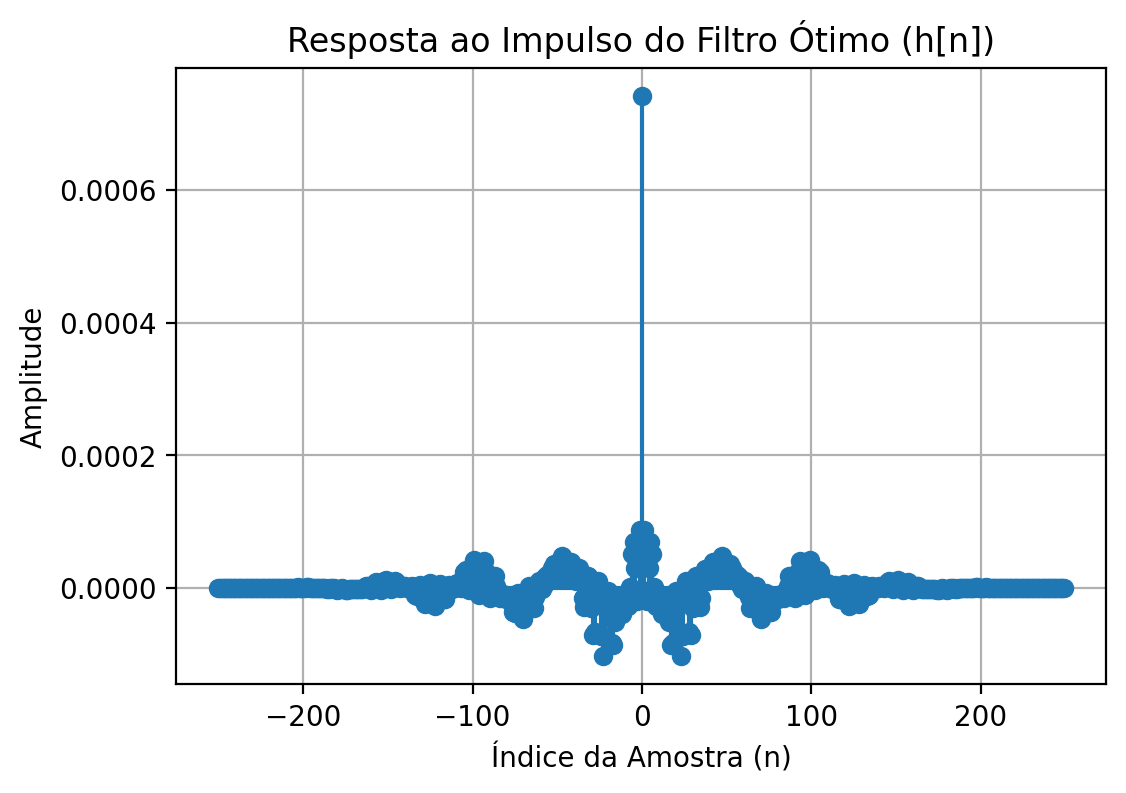

--- Gerando o Dataset Sintético ---
Fator de escala : 1.0224
--- Analisando o Dataset Sintético via Wiener-Khinchin ---
--- Gerando Gráficos de Validação Final ---


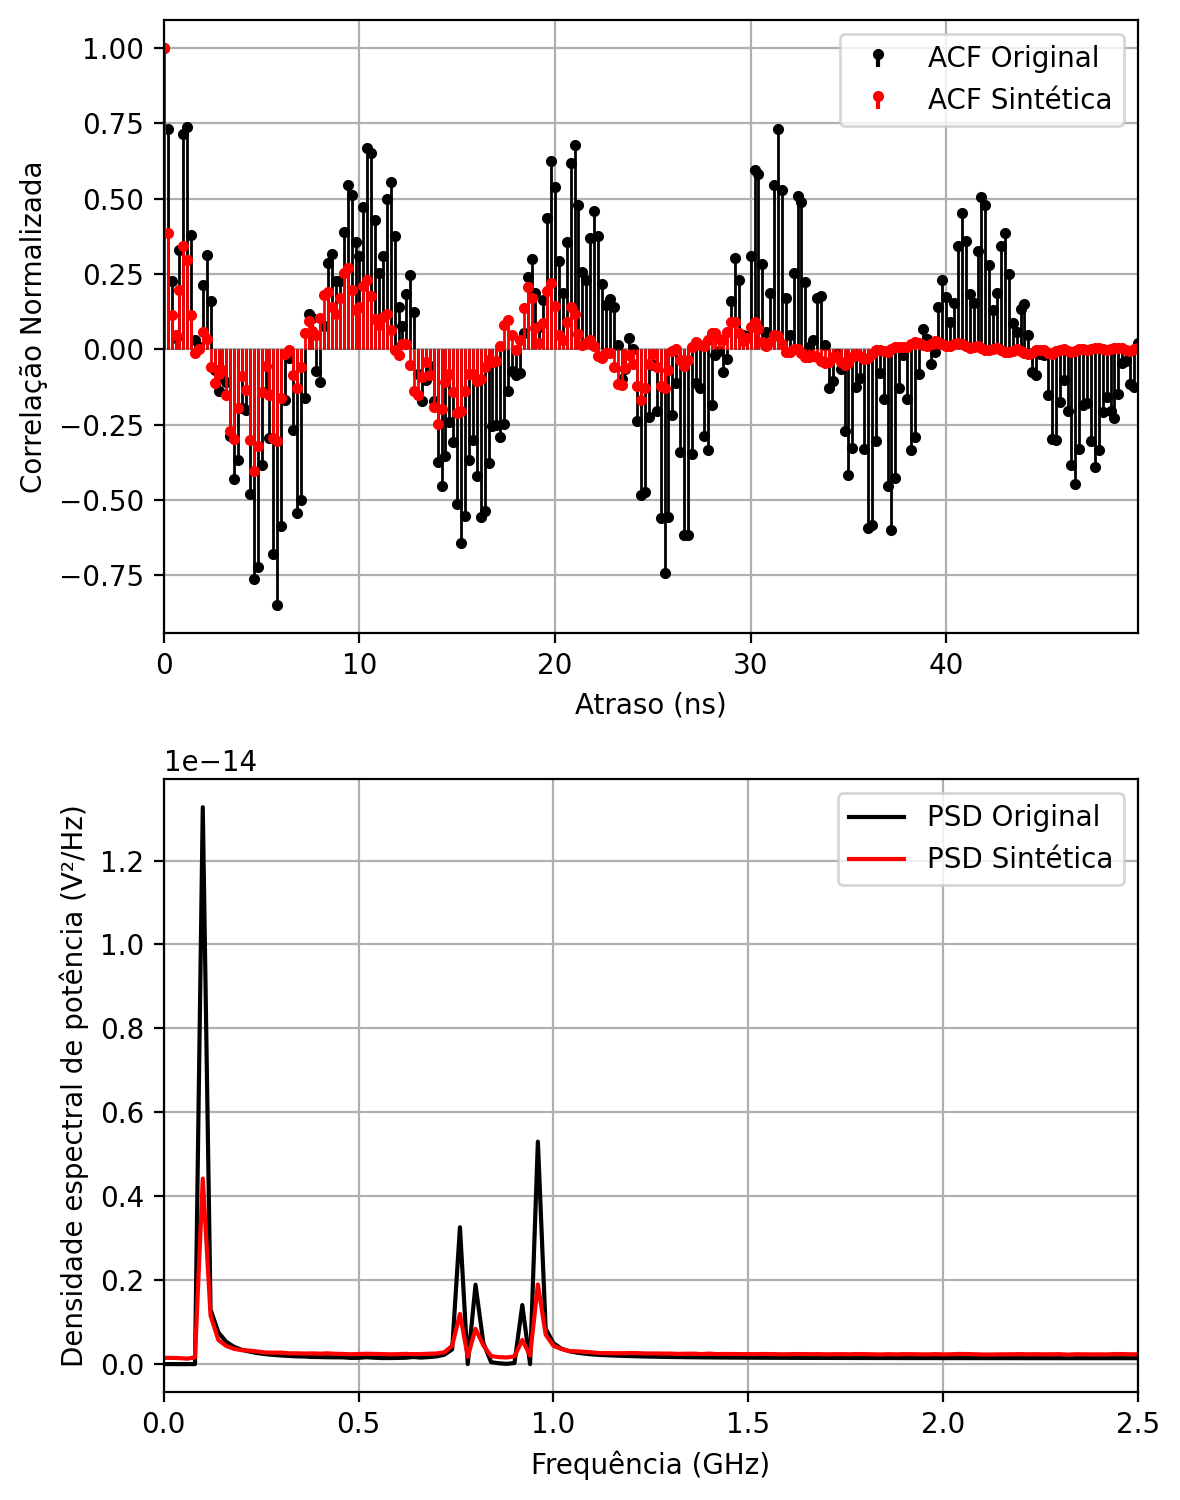

In [ ]:
psd_original = psd_via_acf
freqs_original = freqs_via_acf

# --- 3. Plotar os Coeficientes h[n] ---
plt.figure(figsize=(6, 4), dpi=200)
plt.stem(np.arange(len(coeficientes_h_n)) - len(coeficientes_h_n)//2, coeficientes_h_n, basefmt='')
plt.title('Resposta ao Impulso do Filtro Ótimo (h[n])')
plt.xlabel('Índice da Amostra (n)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Calcular a ACF normalizada apenas para o plot
acf_original_normalized = acf_via_matrix_unnormalized / acf_via_matrix_unnormalized[0]

# --- 2. GERAÇÃO DO DATASET SINTÉTICO ---
print("--- Gerando o Dataset Sintético ---")

potencia_original = np.mean(np.var(dataset, axis=1))

dataset_sintetico = []

for i in range(num_instancias):
    white_noise = np.random.randn(num_amostras)

    y_n = signal.convolve(white_noise, coeficientes_h_n, mode='same')

    dataset_sintetico.append(y_n)

dataset_sintetico = np.array(dataset_sintetico)
#dataset_sintetico_final = dataset_sintetico * fator_escala
dataset_sintetico_final = dataset_sintetico

# --- 3. ANÁLISE DO DATASET SINTÉTICO (Usando o mesmo método) ---
print("--- Analisando o Dataset Sintético via Wiener-Khinchin ---")
autocorr_matrix_sintetica = (dataset_sintetico_final.T @ dataset_sintetico_final) / num_instancias
acf_sintetica_unnormalized = []
for lag in range(nlags):
    acf_sintetica_unnormalized.append(np.mean(np.diagonal(autocorr_matrix_sintetica, offset=lag)))
acf_sintetica_unnormalized = np.array(acf_sintetica_unnormalized)
acf_sintetica_normalized = acf_sintetica_unnormalized / acf_sintetica_unnormalized[0]
psd_sintetica = 2 * Ts * np.fft.rfft(acf_sintetica_unnormalized).real
psd_sintetica = np.maximum(psd_sintetica, 0)
freqs_sinteticas = np.fft.rfftfreq(nlags, d=Ts)

# --- 4. Plotar a Comparação Final ---
print("--- Gerando Gráficos de Validação Final ---")
eixo_lags = np.arange(nlags) * Ts * 1e9

plt.figure(figsize=(6, 8), dpi=200)

# Subplot
ax1 = plt.subplot(2, 1, 1)

# ACF original
stem1 = ax1.stem(eixo_lags, acf_original_normalized, linefmt='k-', markerfmt='ko', basefmt=' ', label='ACF Original')
plt.setp(stem1.markerline, markersize=3)
plt.setp(stem1.stemlines, linewidth=1)
# ACF sintética
stem2 = ax1.stem(eixo_lags, acf_sintetica_normalized, linefmt='r-', markerfmt='ro', basefmt=' ', label='ACF Sintética')
plt.setp(stem2.markerline, markersize=3)
plt.setp(stem2.stemlines, linewidth=1)
# Eixos e rótulos
ax1.set_xlabel('Atraso (ns)')
ax1.set_ylabel('Correlação Normalizada')
ax1.grid(True)
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.legend()

# Comparação das PSDs
ax2 = plt.subplot(2, 1, 2)
ax2.plot(freqs_original / 1e9, psd_original, label='PSD Original', color = 'k')
ax2.plot(freqs_sinteticas / 1e9, psd_sintetica, label='PSD Sintética', color='r')
#ax2.set_title('Comparação de Densidade Espectral de Potência Média')
ax2.set_xlabel('Frequência (GHz)')
ax2.set_ylabel('Densidade espectral de potência (V²/Hz)')
ax2.grid(True, which="both")
ax2.autoscale(1,'x', 1)
ax2.legend()

#plt.semilogy()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

--- Gerando uma instância de sinal sintético... ---
Fator de escala : 1.0000
--- Gerando gráfico de comparação... ---


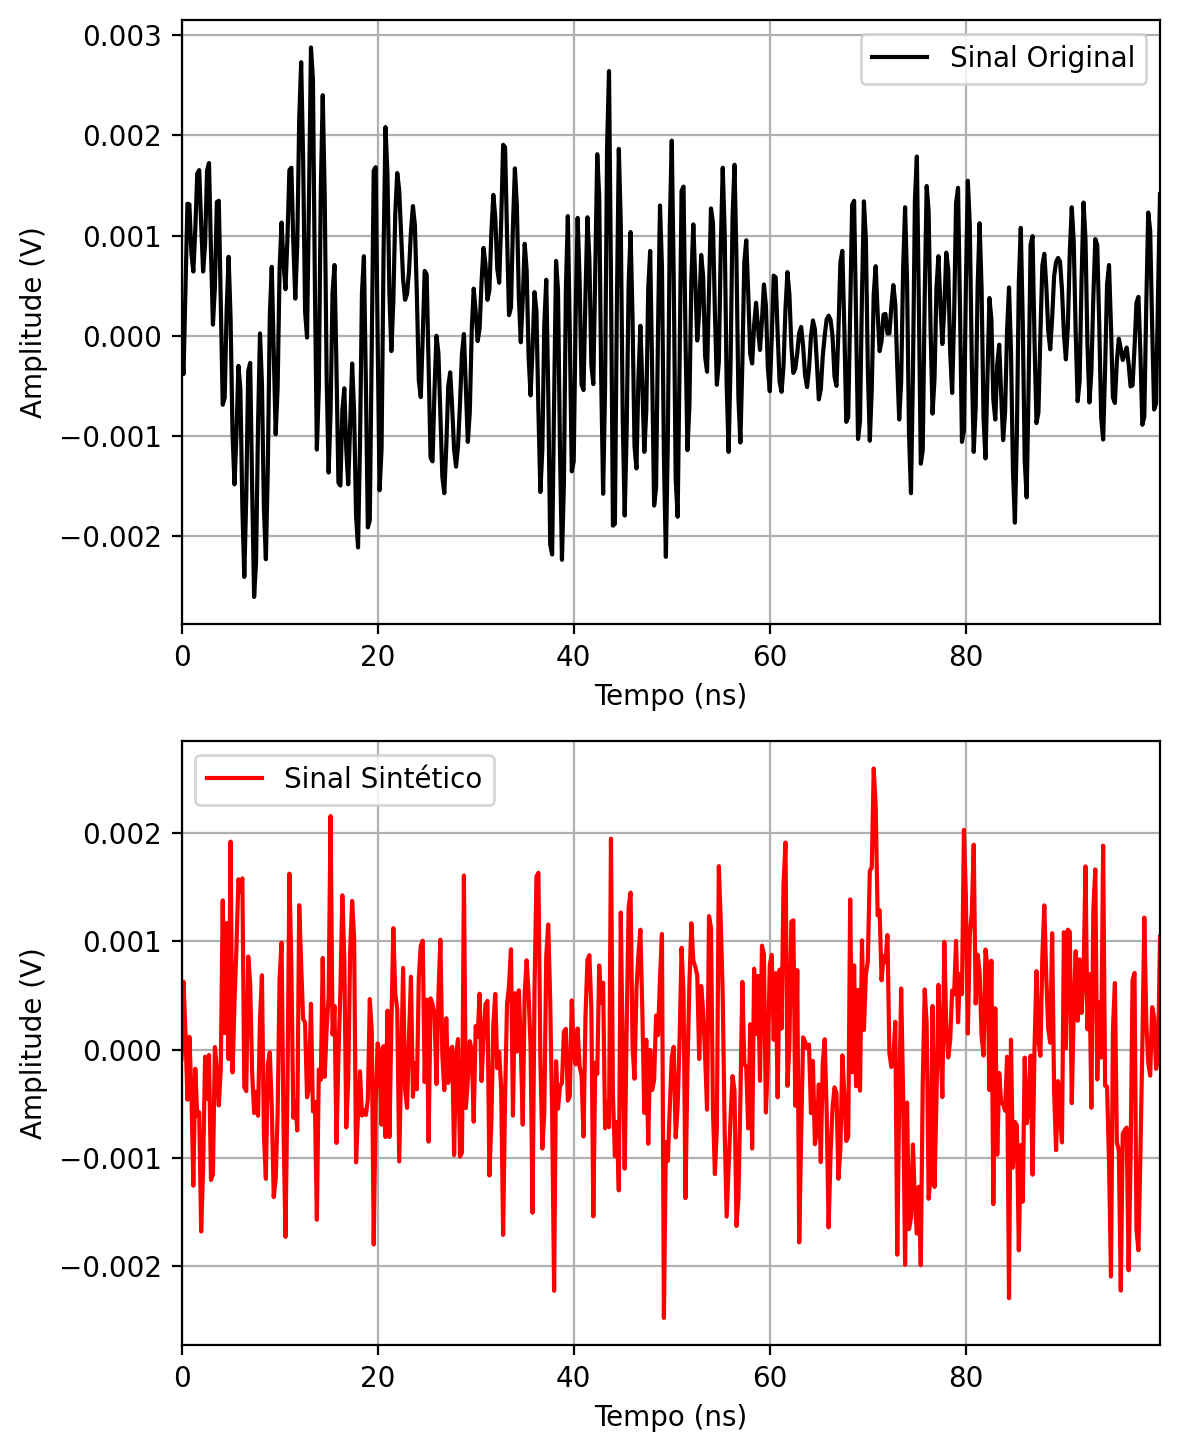

In [ ]:
# --- 2. Gerar UMA Instância Sintética ---
print("--- Gerando uma instância de sinal sintético... ---")

# Usar uma semente para garantir que o resultado seja sempre o mesmo
#np.random.seed(101)
white_noise = np.random.randn(num_amostras)
#W_f = np.fft.rfft(white_noise)

# Interpolar H(f) para garantir compatibilidade de tamanho
#H_f_interpolado = np.interp(np.linspace(0, 1, len(W_f)), np.linspace(0, 1, len(H_f)), H_f)

# Aplicar o filtro
#Y_f = H_f_interpolado * W_f
#sinal_sintetico = np.fft.irfft(Y_f)

sinal_sintetico = np.convolve(white_noise, coeficientes_h_n, mode='same')

sinal_sintetico_final = sinal_sintetico

# --- 3. Plotar a Comparação Lado a Lado ---
print("--- Gerando gráfico de comparação... ---")

# Escolher uma instância do dataset original para plotar (ex: a primeira)
i = np.random.randint(0, len(dataset))
sinal_real = dataset[i]

# Criar o eixo do tempo para os gráficos
eixo_tempo = np.arange(num_amostras) * Ts * 1e9 # em nanosegundos

plt.figure(figsize=(6, 8), dpi=200)

# Plotar o sinal real
plt.subplot(2, 1, 1)
plt.plot(eixo_tempo, sinal_real, label='Sinal Original', color = 'k')
plt.xlabel('Tempo (ns)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.grid(True)
plt.autoscale(1,'x', 1)

# Histograma das variâncias temporais
plt.subplot(2, 1, 2)
plt.plot(eixo_tempo, sinal_sintetico_final, label='Sinal Sintético', color='r')
plt.xlabel('Tempo (ns)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.grid(True)
plt.autoscale(1,'x', 1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

--- Gerando uma instância de sinal sintético... ---
Fator de escala : 1.0000
--- Gerando gráfico de comparação... ---


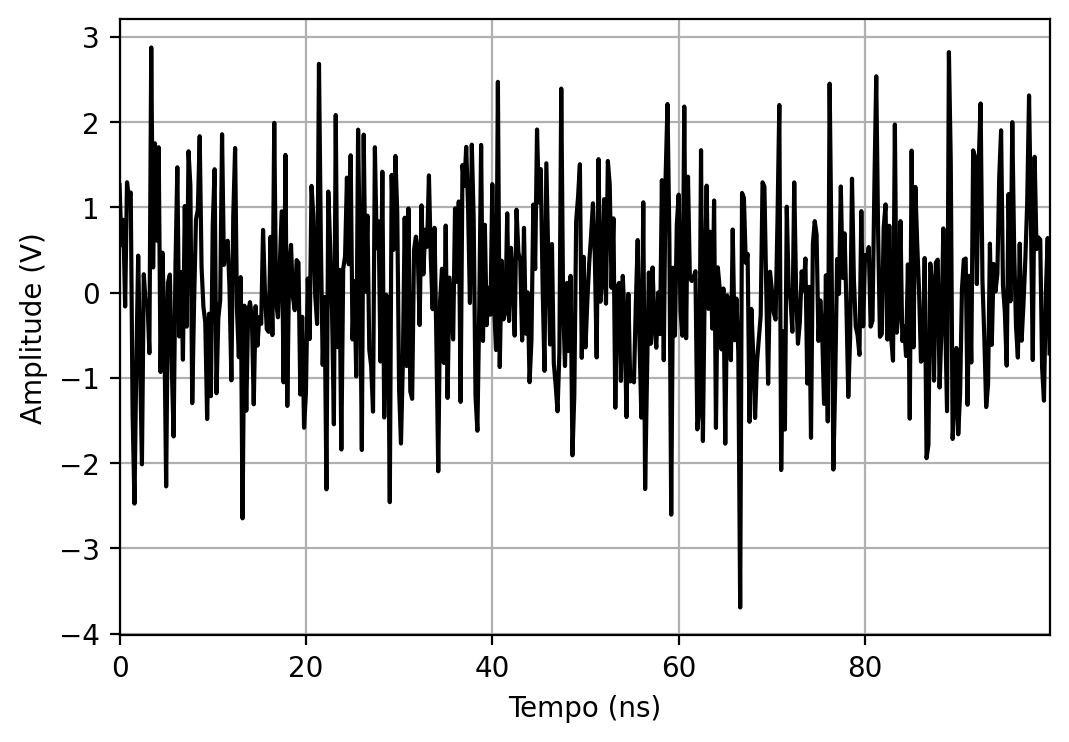

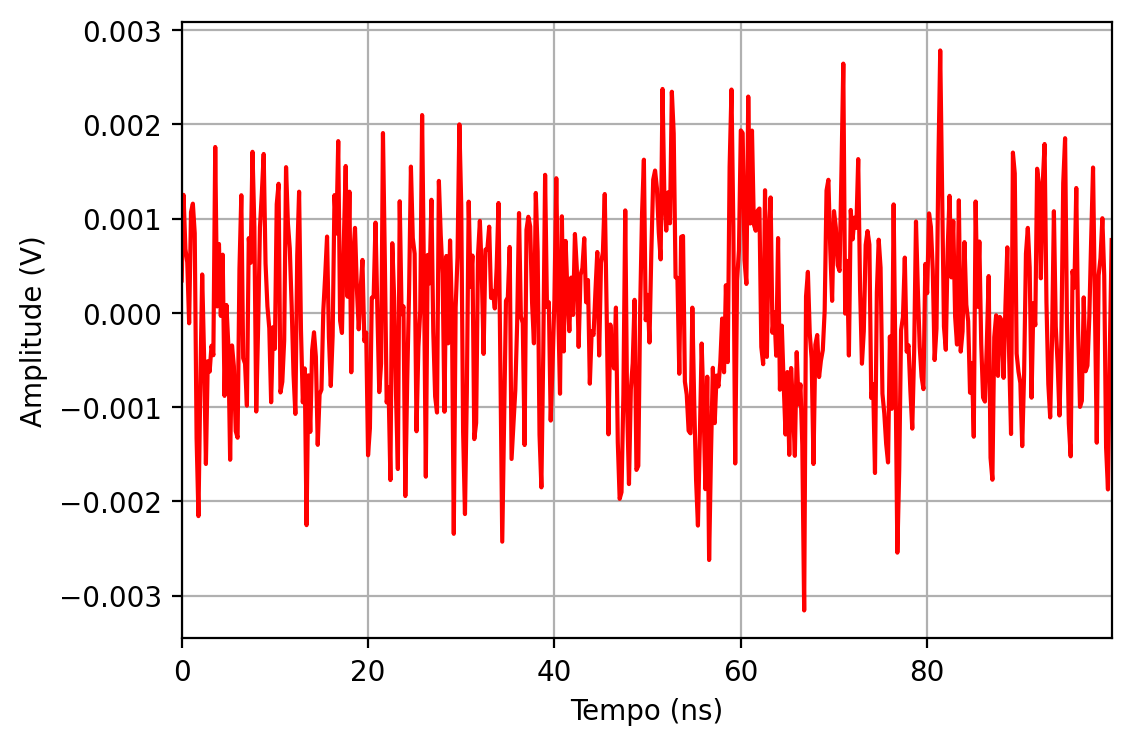

In [ ]:
# --- 2. Gerar UMA Instância Sintética ---
print("--- Gerando uma instância de sinal sintético... ---")

# Usar uma semente para garantir que o resultado seja sempre o mesmo
#np.random.seed(101)
white_noise = np.random.randn(num_amostras)
#W_f = np.fft.rfft(white_noise)

# Interpolar H(f) para garantir compatibilidade de tamanho
#H_f_interpolado = np.interp(np.linspace(0, 1, len(W_f)), np.linspace(0, 1, len(H_f)), H_f)

# Aplicar o filtro
#Y_f = H_f_interpolado * W_f
#sinal_sintetico = np.fft.irfft(Y_f)

sinal_sintetico = np.convolve(white_noise, coeficientes_h_n, mode='same')

sinal_sintetico_final = sinal_sintetico

# --- 3. Plotar a Comparação Lado a Lado ---
print("--- Gerando gráfico de comparação... ---")

# Escolher uma instância do dataset original para plotar (ex: a primeira)
i = np.random.randint(0, len(dataset))
sinal_real = dataset[i]

# Criar o eixo do tempo para os gráficos
eixo_tempo = np.arange(num_amostras) * Ts * 1e9 # em nanosegundos

plt.figure(figsize=(6, 4), dpi=200)

# Plotar o sinal real
plt.plot(eixo_tempo, white_noise, label='Ruído branco', color = 'k')
plt.xlabel('Tempo (ns)')
plt.ylabel('Amplitude (V)')
#plt.legend()
plt.grid(True)
plt.autoscale(1,'x', 1)

plt.figure(figsize=(6, 4), dpi=200)
plt.plot(eixo_tempo, sinal_sintetico_final, label='Sinal Sintético', color='r')
plt.xlabel('Tempo (ns)')
plt.ylabel('Amplitude (V)')
#plt.legend()
plt.grid(True)
plt.autoscale(1,'x', 1)
plt.show()